# Cuaderno de Ingeniería de Características con NLP
 
## **Objetivo:** Analizar la columna `description` para extraer nuevas características que mejoren el rendimiento de nuestro modelo de predicción de precios.

# Fase 1: Carga de Datos y Preparación del Texto

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
import warnings
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Ignorar advertencias para una salida más limpia
warnings.simplefilter(action='ignore', category=FutureWarning)

# Descargar recursos de NLTK (solo la primera vez)
try:
    stopwords.words('spanish')
except LookupError:
    print("Descargando recursos de NLTK (stopwords)...")
    nltk.download('stopwords')

# Cargar las variables de entorno
load_dotenv(dotenv_path='../.env')

def get_descriptions_from_db():
    """
    Se conecta a la base de datos y carga las columnas 'description' y 'price_usd'.
    """
    try:
        db_user = os.getenv("DB_USER")
        db_password = os.getenv("DB_PASSWORD")
        db_host = os.getenv("DB_HOST")
        db_name = os.getenv("DB_NAME")
        
        db_uri = f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}"
        engine = create_engine(db_uri)
        
        print("✅ Conectado a la base de datos. Cargando descripciones...")
        query = "SELECT description, price_usd FROM propiedades WHERE description IS NOT NULL AND description != ''"
        df = pd.read_sql(query, engine)
        print(f"✅ Se cargaron {len(df)} descripciones.")
        return df
    except Exception as e:
        print(f"❌ Error al cargar datos desde MySQL: {e}")
        return None

# Cargar los datos
df_nlp = get_descriptions_from_db()

if df_nlp is not None:
    display(df_nlp.head())


✅ Conectado a la base de datos. Cargando descripciones...
✅ Se cargaron 50266 descripciones.


,description,price_usd
0,"Venta departamento de 3 ambientes con balcón, ...",94500.0
1,Ventaluminoso departamento de 4 ambientes con ...,190000.0
2,Corredor Responsable: Ariel Champanier cucicba...,44500.0
3,Departamento o estudio profesional.,327420.0
4,Corredor Responsable: Raul Hector Merlo cucicb...,345000.0


# Fase 2: Limpieza de Texto y Tokenización

Crear una función para pre-procesar el texto: convertir a minúsculas, eliminar puntuación, números y "stopwords" (palabras comunes como 'de', 'la', 'que', etc.).

In [2]:
# Obtener lista de stopwords
stop_words = set(stopwords.words('spanish'))

def limpiar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar caracteres no alfabeticos
    texto = re.sub(r'[^a-záéíóúüñ\s]', '', texto)
    # Tokenizar (dividir el texto en palabras)
    palabras = texto.split()
    # Eliminar stopwords
    palabras_filtradas = [palabra for palabra in palabras if palabra not in stop_words and len(palabra) > 2]
    return palabras_filtradas

if df_nlp is not None:
    # Aplicamos la limpieza a la columna 'description'
    # 'tqdm' es una librería opcional que muestra una barra de progreso. 
    # Si no se tiene, sacar .progress_apply y usar .apply
    try:
        from tqdm import tqdm
        tqdm.pandas()
        df_nlp['tokens'] = df_nlp['description'].progress_apply(limpiar_texto)
    except ImportError:
        print("Librería 'tqdm' no encontrada. Aplicando sin barra de progreso...")
        df_nlp['tokens'] = df_nlp['description'].apply(limpiar_texto)
        
    print("\nDataFrame con tokens (palabras limpias):")
    display(df_nlp.head())


100%|███████████████████████████████████| 50266/50266 [00:06<00:00, 7922.26it/s]


DataFrame con tokens (palabras limpias):


,description,price_usd,tokens
0,"Venta departamento de 3 ambientes con balcón, ...",94500.0,"[venta, departamento, ambientes, balcón, prime..."
1,Ventaluminoso departamento de 4 ambientes con ...,190000.0,"[ventaluminoso, departamento, ambientes, coche..."
2,Corredor Responsable: Ariel Champanier cucicba...,44500.0,"[corredor, responsable, ariel, champanier, cuc..."
3,Departamento o estudio profesional.,327420.0,"[departamento, estudio, profesional]"
4,Corredor Responsable: Raul Hector Merlo cucicb...,345000.0,"[corredor, responsable, raul, hector, merlo, c..."


# Fase 3: Análisis de Frecuencia de Palabras

Ahora que se conocen las palabras limpias, hay que cuáles son las más comunes en todo el dataset.

In [3]:
if df_nlp is not None:
    # Juntamos todas las listas de tokens en una sola gran lista de palabras
    todas_las_palabras = [palabra for lista_tokens in df_nlp['tokens'] for palabra in lista_tokens]
    
    # Contamos la frecuencia de cada palabra
    conteo_palabras = Counter(todas_las_palabras)
    
    # Mostramos las 30 palabras más comunes
    print("Las 30 palabras más comunes en las descripciones son:")
    display(conteo_palabras.most_common(30))


Las 30 palabras más comunes en las descripciones son:


[('cocina', 58427),
 ('ambientes', 55239),
 ('departamento', 47583),
 ('baño', 45778),
 ('piso', 45458),
 ('balcón', 43524),
 ('edificio', 40693),
 ('propiedad', 40228),
 ('comedor', 39396),
 ('medidas', 39126),
 ('datos', 35150),
 ('living', 35099),
 ('expensas', 31785),
 ('frente', 31200),
 ('inmueble', 30477),
 ('completo', 30296),
 ('pisos', 29512),
 ('cuenta', 29374),
 ('ley', 29056),
 ('dormitorio', 27460),
 ('inmobiliario', 26252),
 ('venta', 25897),
 ('excelente', 25396),
 ('dormitorios', 24527),
 ('dos', 24058),
 ('presente', 23208),
 ('servicios', 23106),
 ('amplio', 23016),
 ('espacio', 22275),
 ('aviso', 21621)]

# Fase 4: Visualización de las Palabras Más Frecuentes

Un gráfico de barras es una excelente manera de visualizar estos resultados.

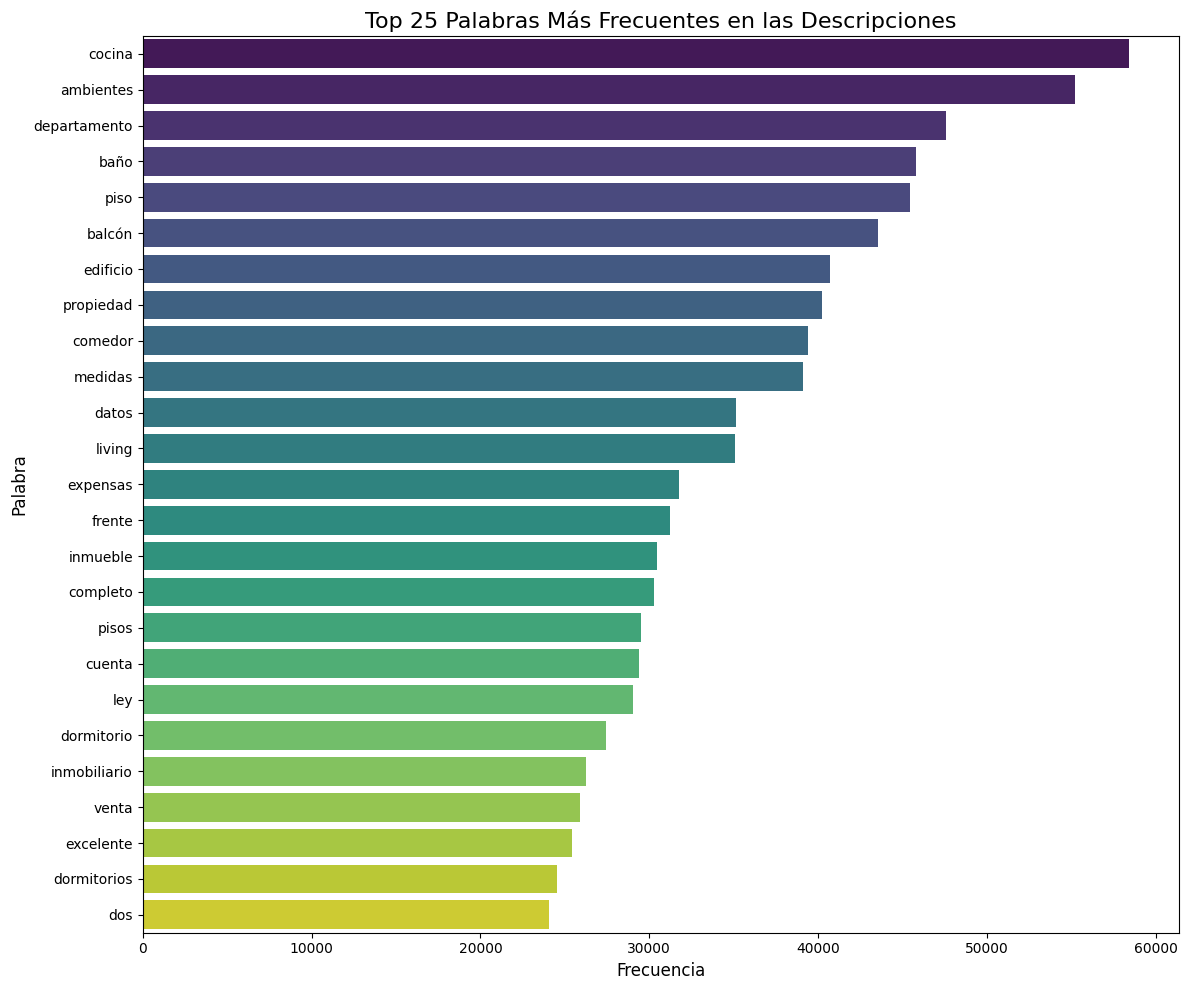

In [4]:
if 'conteo_palabras' in locals():
    # Creamos un DataFrame a partir de los resultados del conteo
    df_frecuencia = pd.DataFrame(conteo_palabras.most_common(25), columns=['palabra', 'frecuencia'])
    
    plt.figure(figsize=(12, 10))
    sns.barplot(data=df_frecuencia, y='palabra', x='frecuencia', palette='viridis')
    plt.title('Top 25 Palabras Más Frecuentes en las Descripciones', fontsize=16)
    plt.xlabel('Frecuencia', fontsize=12)
    plt.ylabel('Palabra', fontsize=12)
    plt.tight_layout()
    plt.show()